In [ ]:
!pip install --no-cache-dir -q git+https://github.com/LosVolterrosHermanos/Experimental.git@everettk/moe_plrf

  Preparing metadata (setup.py) ... done


In [ ]:
# MoE PLRF: Stochastic vs ODE Comparison
"""
This notebook compares stochastic training of Mixture of Experts PLRF models
with theoretical ODE predictions.
"""

#@title Setup and Imports
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from typing import NamedTuple, Callable, Dict, List
import numpy as np

from power_law_rf.optimizers import powerlaw_schedule, dana_optimizer

# Import MoE PLRF implementations from installed package
from power_law_rf.moe_plrf.moe_plrf import (
    TwoExpertPLRF,
    MoEPLRFTrainer,
    MixtureOfExpertsPLRF
)
# from power_law_rf.moe_plrf.moe_plrf_ode import (
#     ode_moe_dana_log_implicit,
#     MoEODEInputs
# )
from power_law_rf.ode import DanaHparams
import power_law_rf.deterministic_equivalent as theory

# Set random seed
key = random.PRNGKey(42)

In [24]:
import jax
import jax.numpy as jnp
from typing import NamedTuple, Callable, Union, Optional, Literal
from power_law_rf.ode import DanaHparams


class MoEODEInputs(NamedTuple):
    eigs_K: jnp.ndarray          # eigenvalues of covariance matrix (W^TDW)
    rho_init: jnp.ndarray        # initial rho_j's (rho_j^2)
    chi_init: jnp.ndarray        # initialization of chi's
    sigma_init: jnp.ndarray      # initialization of sigma's (xi^2_j)
    risk_infinity: float         # risk value at time infinity
    expert_probs: jnp.ndarray    # expert selection probabilities p(i), shape (m,)


def ode_moe_dana_log_implicit(
    inputs: MoEODEInputs,
    opt_hparams: DanaHparams,
    batch: int,
    D: int,
    m: int,  # number of experts
    t_max: float,
    dt: float,
    approximate: bool = False,
    adaptive: Optional[Literal['adam', 'rmsprop_dana']] = None,
):
    """Generate the theoretical solution for MoE PLRF with DANA.
    Outputs TWICE the risk. Vectorized version processes all experts simultaneously.
    Assumes the loss is AVERAGED over the batch, not summed.

    Parameters
    ----------
    inputs : MoEODEInputs
        eigs_K : array d
            eigenvalues of covariance matrix (W^TDW)
        rho_init : array d
            initial rho_j's (rho_j^2)
        chi_init : array (d)
            initialization of chi's
        sigma_init : array (d)
            initialization of sigma's (xi^2_j)
        risk_infinity : scalar
            represents the risk value at time infinity
        expert_probs : array (m)
            expert selection probabilities p(i)

    opt_hparams : optimizer hyperparameters for Dana
        g1, g2, g3 : function(time)
            learning rate functions
        delta : function(time)
            momentum function

    batch : int
        batch size
    D : int
        number of eigenvalues (i.e. shape of eigs_K)
    m : int
        number of experts
    t_max : float
        The number of epochs
    dt : float
        time step used in Euler
    approximate : bool
        Whether to use the approximate ODE (drops higher order terms)
    adaptive : Optional[Literal['adam', 'rmsprop_dana']]
        Type of adaptive optimizer normalization:
        - None: no normalization
        - 'adam': normalize g3 terms (momentum entering parameters)
        - 'rmsprop_dana': normalize g1 terms (gradients entering momentum)

    Returns
    -------
    t_grid: numpy.array(float)
        the time steps used, which will discretize (0,t_max) into n_grid points
    expert_twice_risks: numpy.array(float)
        twice the values of the risk for each expert, shape (n_times, m)
    total_twice_risks: numpy.array(float)
        twice the total MoE risk, shape (n_times,)
    """
    g1_fn, g2_fn, g3_fn, delta_fn = opt_hparams.g1, opt_hparams.g2, opt_hparams.g3, opt_hparams.delta
    eigs_K = inputs.eigs_K
    expert_probs = inputs.expert_probs  # shape (m,)

    # Initialize m copies of the state variables
    # Shape: (3, D, m) where 3 is for [rho, sigma, chi]
    rho_init_all = jnp.tile(inputs.rho_init[:, None], (1, m))
    chi_init_all = jnp.tile(inputs.chi_init[:, None], (1, m))
    sigma_init_all = jnp.tile(inputs.sigma_init[:, None], (1, m))

    twice_risk_infinity = 2.0 * inputs.risk_infinity
    times = jnp.arange(0, jnp.log(t_max), step=dt, dtype=jnp.float32)

    # Initial risks for each expert
    risk_init_all = twice_risk_infinity + jnp.sum(inputs.eigs_K[:, None] * rho_init_all, axis=0)

    def get_normalization_factors(grad_norm):
        """Compute normalization factors based on adaptive optimizer type."""
        if adaptive == 'adam':
            return jnp.ones_like(grad_norm), grad_norm
        elif adaptive == 'rmsprop_dana':
            return grad_norm, jnp.ones_like(grad_norm)
        else:
            return jnp.ones_like(grad_norm), jnp.ones_like(grad_norm)

    def inverse_3x3(omega):
        """Vectorized inverse for shape (m, 3, 3, D) -> (m, 3, 3, D)"""
        # Extract elements - shape (m, D)
        a11, a12, a13 = omega[:, 0, 0], omega[:, 0, 1], omega[:, 0, 2]
        a21, a22, a23 = omega[:, 1, 0], omega[:, 1, 1], omega[:, 1, 2]
        a31, a32, a33 = omega[:, 2, 0], omega[:, 2, 1], omega[:, 2, 2]

        det = (a11*a22*a33 + a12*a23*a31 + a13*a21*a32
               - a13*a22*a31 - a11*a23*a32 - a12*a21*a33)

        # Build inverse matrix
        inv = jnp.zeros_like(omega)

        inv = inv.at[:, 0, 0].set((a22*a33 - a23*a32) / det)
        inv = inv.at[:, 0, 1].set((a13*a32 - a12*a33) / det)
        inv = inv.at[:, 0, 2].set((a12*a23 - a13*a22) / det)

        inv = inv.at[:, 1, 0].set((a23*a31 - a21*a33) / det)
        inv = inv.at[:, 1, 1].set((a11*a33 - a13*a31) / det)
        inv = inv.at[:, 1, 2].set((a13*a21 - a11*a23) / det)

        inv = inv.at[:, 2, 0].set((a21*a32 - a22*a31) / det)
        inv = inv.at[:, 2, 1].set((a12*a31 - a11*a32) / det)
        inv = inv.at[:, 2, 2].set((a11*a22 - a12*a21) / det)

        return inv

    def omega_full_all(time_plus, grad_norm_all):
        """Compute omega for all experts at once - shape (m, 3, 3, D)"""
        # Get normalization factors for each expert
        g1_norm_all, g3_norm_all = get_normalization_factors(grad_norm_all)

        # Normalize hyperparameters and ensure consistent shapes
        g1 = g1_fn(time_plus) / g1_norm_all[:, None]        # (m, 1) for broadcasting
        g2 = g2_fn(time_plus) * jnp.ones((m, 1))            # (m, 1) for broadcasting
        g3 = g3_fn(time_plus) / g3_norm_all[:, None]        # (m, 1) for broadcasting
        delta = delta_fn(time_plus)                         # scalar

        # Broadcast everything to shape (m, D)
        p = expert_probs[:, None]                            # (m, 1) -> broadcasts to (m, D)
        eigs = eigs_K[None, :]                               # (1, D) -> broadcasts to (m, D)
        ones = jnp.ones((m, D))                              # (m, D)

        # Compute MoE scaling factors
        mean_gradient_scaling = p
        second_moment_scaling = p * (2.0 - p + batch * p) / (batch + 1.0)

        omega_all = jnp.zeros((m, 3, 3, D))

        # Row 1: Evolution of rho
        omega_all = omega_all.at[:, 0, 0].set(
            -2.0 * mean_gradient_scaling * (g2 + g1 * g3) * eigs +
            second_moment_scaling * ((batch + 1.0) / batch) * (g2**2 + 2.0 * g1 * g3 * g2 + g1**2 * g3**2) * eigs**2
        )
        omega_all = omega_all.at[:, 0, 1].set(
            g3**2 * (1.0 - delta)**2 * ones
        )
        omega_all = omega_all.at[:, 0, 2].set(
            -2.0 * g3 * (1.0 - delta) * ones +
            2.0 * mean_gradient_scaling * (g2 * g3 + g3**2 * g1) * (1.0 - delta) * eigs
        )

        # Row 2: Evolution of sigma
        omega_all = omega_all.at[:, 1, 0].set(
            second_moment_scaling * ((batch + 1.0) / batch) * g1**2 * eigs**2
        )
        omega_all = omega_all.at[:, 1, 1].set(
            (-2.0 * delta + delta**2) * ones
        )
        omega_all = omega_all.at[:, 1, 2].set(
            2.0 * mean_gradient_scaling * g1 * eigs * (1.0 - delta) * ones
        )

        # Row 3: Evolution of chi
        omega_all = omega_all.at[:, 2, 0].set(
            mean_gradient_scaling * g1 * eigs -
            second_moment_scaling * ((batch + 1.0) / batch) * eigs**2 * (g1 * g2 + g1**2 * g3)
        )
        omega_all = omega_all.at[:, 2, 1].set(
            (-g3 + g3 * delta * (2.0 - delta)) * ones
        )
        omega_all = omega_all.at[:, 2, 2].set(
            -delta * ones -
            mean_gradient_scaling * (g2 - g2 * delta + 2.0 * (1.0 - delta) * g1 * g3) * eigs
        )

        return omega_all


    def omega_approximate_all(time_plus, grad_norm_all):
        """Compute approximate omega for all experts - shape (m, 3, 3, D)"""
        # Get normalization factors for each expert
        g1_norm_all, g3_norm_all = get_normalization_factors(grad_norm_all)

        # Normalize hyperparameters and ensure consistent shapes
        g1 = g1_fn(time_plus) / g1_norm_all[:, None]        # (m, 1) for broadcasting
        g2 = g2_fn(time_plus) * jnp.ones((m, 1))            # (m, 1) for broadcasting
        g3 = g3_fn(time_plus) / g3_norm_all[:, None]        # (m, 1) for broadcasting
        delta = delta_fn(time_plus)                         # scalar

        # Broadcast for cleaner expressions
        p = expert_probs[:, None]                            # (m, 1)
        eigs = eigs_K[None, :]                               # (1, D)
        ones = jnp.ones((m, D))                              # (m, D)
        zeros = jnp.zeros((m, D))                            # (m, D)

        # MoE scaling
        mean_gradient_scaling = p

        omega_all = jnp.zeros((m, 3, 3, D))

        omega_all = omega_all.at[:, 0, 0].set(-2.0 * mean_gradient_scaling * g2 * eigs)
        omega_all = omega_all.at[:, 0, 1].set(zeros)
        omega_all = omega_all.at[:, 0, 2].set(-2.0 * g3 * ones)

        omega_all = omega_all.at[:, 1, 0].set(zeros)
        omega_all = omega_all.at[:, 1, 1].set(-2.0 * delta * ones)
        omega_all = omega_all.at[:, 1, 2].set(2.0 * mean_gradient_scaling * g1 * eigs * ones)

        omega_all = omega_all.at[:, 2, 0].set(mean_gradient_scaling * g1 * eigs)
        omega_all = omega_all.at[:, 2, 1].set(-g3 * ones)
        omega_all = omega_all.at[:, 2, 2].set(-delta * ones - mean_gradient_scaling * g2 * eigs)

        return omega_all


    def forcing_term_all(time_plus, grad_norm_all):
        """Compute forcing term for all experts - shape (m, 3, D)"""
        # Get normalization factors for each expert
        g1_norm_all, g3_norm_all = get_normalization_factors(grad_norm_all)

        # Normalize hyperparameters
        g1 = g1_fn(time_plus) / g1_norm_all                 # shape (m,)
        g2 = g2_fn(time_plus) * jnp.ones(m)                 # shape (m,)
        g3 = g3_fn(time_plus) / g3_norm_all                 # shape (m,)

        # Gradient noise scaling: same as mean gradient scaling = p(i)
        gradient_noise_scaling = expert_probs                # shape (m,)

        gamma_all = jnp.stack([
            gradient_noise_scaling * (g2**2 + 2.0 * g1 * g2 * g3 + g1**2 * g3**2) / batch,
            gradient_noise_scaling * g1**2 / batch,
            gradient_noise_scaling * (-g1 * g2 - g1**2 * g3) / batch
        ], axis=1)  # shape (m, 3)

        # Broadcast with eigs_K: (m, 3, 1) * (1, 1, D) -> (m, 3, D)
        return gamma_all[:, :, None] * eigs_K[None, None, :]


    def forcing_term_approximate_all(time_plus, grad_norm_all):
        """Compute approximate forcing term for all experts - shape (m, 3, D)"""
        # Get normalization factors for each expert
        g1_norm_all, g3_norm_all = get_normalization_factors(grad_norm_all)

        # Normalize hyperparameters
        g1 = g1_fn(time_plus) / g1_norm_all                 # shape (m,)
        g2 = g2_fn(time_plus) * jnp.ones(m)                 # shape (m,)

        # Gradient noise scaling: same as mean gradient scaling = p(i)
        gradient_noise_scaling = expert_probs                # shape (m,)

        gamma_all = jnp.stack([
            gradient_noise_scaling * g2**2 / batch,
            gradient_noise_scaling * g1**2 / batch,
            jnp.zeros_like(gradient_noise_scaling)
        ], axis=1)  # shape (m, 3)

        # Broadcast with eigs_K: (m, 3, 1) * (1, 1, D) -> (m, 3, D)
        return gamma_all[:, :, None] * eigs_K[None, None, :]

    def ode_update(carry, time):
        v_all, twice_risk_all = carry  # v_all: (3, D, m), twice_risk_all: (m,)
        time_plus = jnp.exp(time + dt)
        time_plus_minus_one = time_plus - 1.0

        # Transpose v_all to (m, 3, D) for easier batch processing
        v_all_transposed = jnp.transpose(v_all, (2, 0, 1))  # (m, 3, D)

        # Use sqrt(risk) as proxy for gradient norm when adaptive is not None
        grad_norm_all = jnp.sqrt(twice_risk_all) if adaptive is not None else jnp.ones(m)

        # Get omega for all experts - shape (m, 3, 3, D)
        omega_all = omega_approximate_all(time_plus_minus_one, grad_norm_all) if approximate else omega_full_all(time_plus_minus_one, grad_norm_all)

        # Create identity matrix broadcasted for all experts
        identity_all = jnp.eye(3)[None, :, :, None] * jnp.ones((m, 1, 1, D))  # (m, 3, 3, D)

        # Compute A for all experts
        A_all = inverse_3x3(identity_all - (dt * time_plus) * omega_all)  # (m, 3, 3, D)

        # Get forcing term for all experts - shape (m, 3, D)
        G_lambda_all = forcing_term_approximate_all(time_plus_minus_one, grad_norm_all) if approximate else forcing_term_all(time_plus_minus_one, grad_norm_all)

        # Compute x_temp for all experts - shape (m, 3, D)
        x_temp_all = v_all_transposed + dt * time_plus * twice_risk_infinity * G_lambda_all

        # Apply A to x_temp: (m, 3, 3, D) @ (m, 3, D) -> (m, 3, D)
        x_all = jnp.einsum('mijk,mjk->mik', A_all, x_temp_all)

        # Apply A to G_lambda
        y_all = jnp.einsum('mijk,mjk->mik', A_all, G_lambda_all)

        # Compute the z terms - shape (m, D)
        z_dot_x = jnp.sum(x_all[:, 0, :] * eigs_K[None, :], axis=1)  # (m,)
        z_dot_y = jnp.sum(y_all[:, 0, :] * eigs_K[None, :], axis=1)  # (m,)

        # Final update for all experts
        scale = (dt * time_plus * z_dot_x / (1.0 - dt * time_plus * z_dot_y))[:, None, None]  # (m, 1, 1)
        v_new_all_transposed = x_all + scale * y_all  # (m, 3, D)

        # Transpose back to (3, D, m)
        v_new_all = jnp.transpose(v_new_all_transposed, (1, 2, 0))

        # Compute new risks for all experts
        twice_risk_new_all = twice_risk_infinity + jnp.sum(eigs_K[:, None] * v_new_all[0, :, :], axis=0)  # (m,)

        # Total MoE risk
        total_twice_risk = jnp.sum(expert_probs * twice_risk_new_all)

        return (v_new_all, twice_risk_new_all), (twice_risk_new_all, total_twice_risk)

    init_v_all = jnp.stack([rho_init_all, sigma_init_all, chi_init_all], axis=0)  # (3, D, m)
    init_carry = (init_v_all, risk_init_all)

    _, (expert_twice_risks, total_twice_risks) = jax.lax.scan(ode_update, init_carry, times)

    return jnp.exp(times)-1.0, expert_twice_risks, total_twice_risks


In [ ]:
#@title Global Parameters
# Model parameters
ALPHA = 1.0
BETA_LIST = [0.5, 0.8, 1.1, 1.4]
# BETA_LIST = [0.8, 1.1]
# BETA_LIST = [0.8]
# BETA = 0.8
V = 2000  # Hidden dimension
D = 500   # Parameter dimension

# MoE parameters
M = 12  # Number of experts for general MoE
P = 0.01  # Probability for expert 2 in two-expert case
ZETA = 1.0  # Power-law exponent for expert selection

# Training parameters
# BATCH_SIZE = 32
STEPS = 10000
DT = 1e-3  # ODE time step

# Learning rate schedules
# BASE_LR = 0.01
# MOMENTUM = 0.9

G2_SCALE = 0.5
G3_IV = 0.1
BATCH_SIZE = 1

def get_traceK(alpha, v):
  x_grid = jnp.arange(1, v+1).reshape(1, v)
  population_eigs = x_grid ** -alpha
  population_trace = jnp.sum(population_eigs**2)
  return population_trace

def get_sgd_hparams(g2_scale, batch_size, traceK):
  learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
  dana_params_sgd = DanaHparams(
    g1=lambda t: 0.0,  # No momentum accumulation
    g2=lambda t: learning_rate,  # Direct gradient update
    g3=lambda t: 0.0,  # No momentum contribution
    delta=lambda t: 1.0  # Full momentum decay
  )
  return dana_params_sgd

def get_dana_constant_hparams(alpha, beta, d, batch_size, g2_scale, g3_iv, traceK):
  learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
  g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1.0)
  g2 = powerlaw_schedule(learning_rate, 0.0, 0.0, 1.0)
  g3 = powerlaw_schedule(g3_iv * batch_size / d, 0.0, 0.0, 1.0)
  delta = powerlaw_schedule(4.0+2*(alpha+beta)/(2*alpha), 0.0, -1.0, 1.0)
  return DanaHparams(g1=g1, g2=g2, g3=g3, delta=delta)

def get_dana_decaying_hparams(alpha, beta, d, batch_size, g2_scale, g3_iv, traceK):
  # kappa_b = jnp.log(batch_size) / jnp.log(d)  # exponent for batch wrt d
  kappa_b = 0.0
  learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
  g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1.0)
  g2 = powerlaw_schedule(learning_rate, 0.0, 0.0, 1.0)
  g3 = powerlaw_schedule(g3_iv, 0.0, -(1.0 - kappa_b) / (2 * alpha), 1.0)
  # delta = powerlaw_schedule(4.0+2*(alpha+beta)/(2*alpha), 0.0, -1.0, 1.0)
  delta = powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(alpha+beta)/(2*alpha))
  return DanaHparams(g1=g1, g2=g2, g3=g3, delta=delta)

traceK = get_traceK(ALPHA, V)
# Examples:
# sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
# sgd_opt = dana_optimizer(sgd_hparams.g1, sgd_hparams.g2, sgd_hparams.g3, sgd_hparams.delta)
# dana_constant_hparams = get_dana_constant_hparams(ALPHA, BETA, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
# dana_constant_opt = dana_optimizer(dana_constant_hparams.g1, dana_constant_hparams.g2, dana_constant_hparams.g3, dana_constant_hparams.delta)
# dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, BETA, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
# dana_decaying_opt = dana_optimizer(dana_decaying_hparams.g1, dana_decaying_hparams.g2, dana_decaying_hparams.g3, dana_decaying_hparams.delta)

In [ ]:
#@title Part 1: Two-Expert Comparison (SGD vs DANA-decaying)
"""
First, we'll compare SGD and DANA-decaying on a two-expert PLRF model
to validate the theoretical predictions about timescale separation.
"""

print("="*60)
print("Two-Expert PLRF: SGD vs DANA-decaying Comparison")
print("="*60)

two_expert_results = []

for beta in BETA_LIST:
    print(f"\nRunning experiments for β = {beta}")

    # Create two-expert model
    key, model_key = random.split(key)
    model = TwoExpertPLRF(
        alpha=ALPHA,
        beta=beta,
        v=V,
        d=D,
        p=P,
        key=model_key
    )

    print(f"  Expert probabilities: p₁ = {1-P:.2f}, p₂ = {P:.2f}")
    print(f"  Optimal risk: {model.optimal_risk():.6f}")

    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    sgd_opt = dana_optimizer(sgd_hparams.g1, sgd_hparams.g2, sgd_hparams.g3, sgd_hparams.delta)
    dana_constant_hparams = get_dana_constant_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_constant_opt = dana_optimizer(dana_constant_hparams.g1, dana_constant_hparams.g2, dana_constant_hparams.g3, dana_constant_hparams.delta)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_decaying_opt = dana_optimizer(dana_decaying_hparams.g1, dana_decaying_hparams.g2, dana_decaying_hparams.g3, dana_decaying_hparams.delta)

    # SGD experiment
    sgd_trainer = MoEPLRFTrainer(model, sgd_opt)

    key, train_key = random.split(key)
    sgd_results = sgd_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    # DANA experiment
    dana_decaying_trainer = MoEPLRFTrainer(model, dana_decaying_opt)

    key, train_key = random.split(key)
    dana_decaying_results = dana_decaying_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    two_expert_results.append({
        'beta': beta,
        'model': model,
        'sgd': sgd_results,
        'dana_decaying': dana_decaying_results,
    })

Two-Expert PLRF: SGD vs DANA-decaying Comparison

Running experiments for β = 0.5
  Expert probabilities: p₁ = 0.99, p₂ = 0.01
  Optimal risk: 0.000023


100%|██████████| 10000/10000 [00:07<00:00, 1346.05it/s]



Running experiments for β = 0.8
  Expert probabilities: p₁ = 0.99, p₂ = 0.01
  Optimal risk: 0.000009


100%|██████████| 10000/10000 [00:07<00:00, 1297.80it/s]



Running experiments for β = 1.1
  Expert probabilities: p₁ = 0.99, p₂ = 0.01
  Optimal risk: 0.000005


100%|██████████| 10000/10000 [00:07<00:00, 1376.29it/s]



Running experiments for β = 1.4
  Expert probabilities: p₁ = 0.99, p₂ = 0.01
  Optimal risk: 0.000005


100%|██████████| 10000/10000 [00:07<00:00, 1324.32it/s]


In [30]:
#@title Part 2: ODE Predictions for Two-Expert Model (Both Approximate and Full)
"""
Now we'll generate ODE predictions for the same two-expert configurations,
running both approximate and full ODE versions.
"""

print("\n" + "="*60)
print("Computing ODE Predictions (Approximate and Full)")
print("="*60)

two_expert_ode_results = []

for result in two_expert_results:
    beta = result['beta']
    model = result['model']

    print(f"\nComputing ODE for β = {beta}")

    # Get theoretical eigenvalues and initial rhos
    fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, D)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)

    # Compute theoretical limit loss
    risk_infty_theory = theory.theory_limit_loss(ALPHA, beta, V, D)

    # Create MoE ODE inputs
    expert_probs = jnp.array([1-P, P])
    ode_inputs = MoEODEInputs(
        eigs_K=fake_eigs,
        rho_init=rho_init,
        chi_init=chi_init,
        sigma_init=sigma_init,
        risk_infinity=risk_infty_theory,
        expert_probs=expert_probs
    )

    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    dana_constant_hparams = get_dana_constant_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)

    # Store results for both approximate and full ODEs
    ode_result_dict = {'beta': beta}

    # Run both approximate and full versions for each optimizer
    for opt_name, opt_hparams in [('sgd', sgd_hparams), ('dana_decaying', dana_decaying_hparams)]:
        print(f"  Running {opt_name}...")

        # Run approximate ODE
        ode_times_approx, expert_risks_approx, total_risk_approx = ode_moe_dana_log_implicit(
            ode_inputs,
            opt_hparams,
            batch=BATCH_SIZE,
            D=D,
            m=2,
            t_max=STEPS,
            dt=DT,
            approximate=True
        )

        # Run full ODE
        ode_times_full, expert_risks_full, total_risk_full = ode_moe_dana_log_implicit(
            ode_inputs,
            opt_hparams,
            batch=BATCH_SIZE,
            D=D,
            m=2,
            t_max=STEPS,
            dt=DT,
            approximate=False
        )

        ode_result_dict[opt_name] = {
            'approx': {
                'times': ode_times_approx,
                'expert_risks': expert_risks_approx / 2,  # Convert to actual risk
                'total_risk': total_risk_approx / 2
            },
            'full': {
                'times': ode_times_full,
                'expert_risks': expert_risks_full / 2,
                'total_risk': total_risk_full / 2
            }
        }

    two_expert_ode_results.append(ode_result_dict)



Computing ODE Predictions (Approximate and Full)

Computing ODE for β = 0.5
  Running sgd...
  Running dana_decaying...

Computing ODE for β = 0.8
  Running sgd...
  Running dana_decaying...

Computing ODE for β = 1.1
  Running sgd...
  Running dana_decaying...

Computing ODE for β = 1.4
  Running sgd...
  Running dana_decaying...


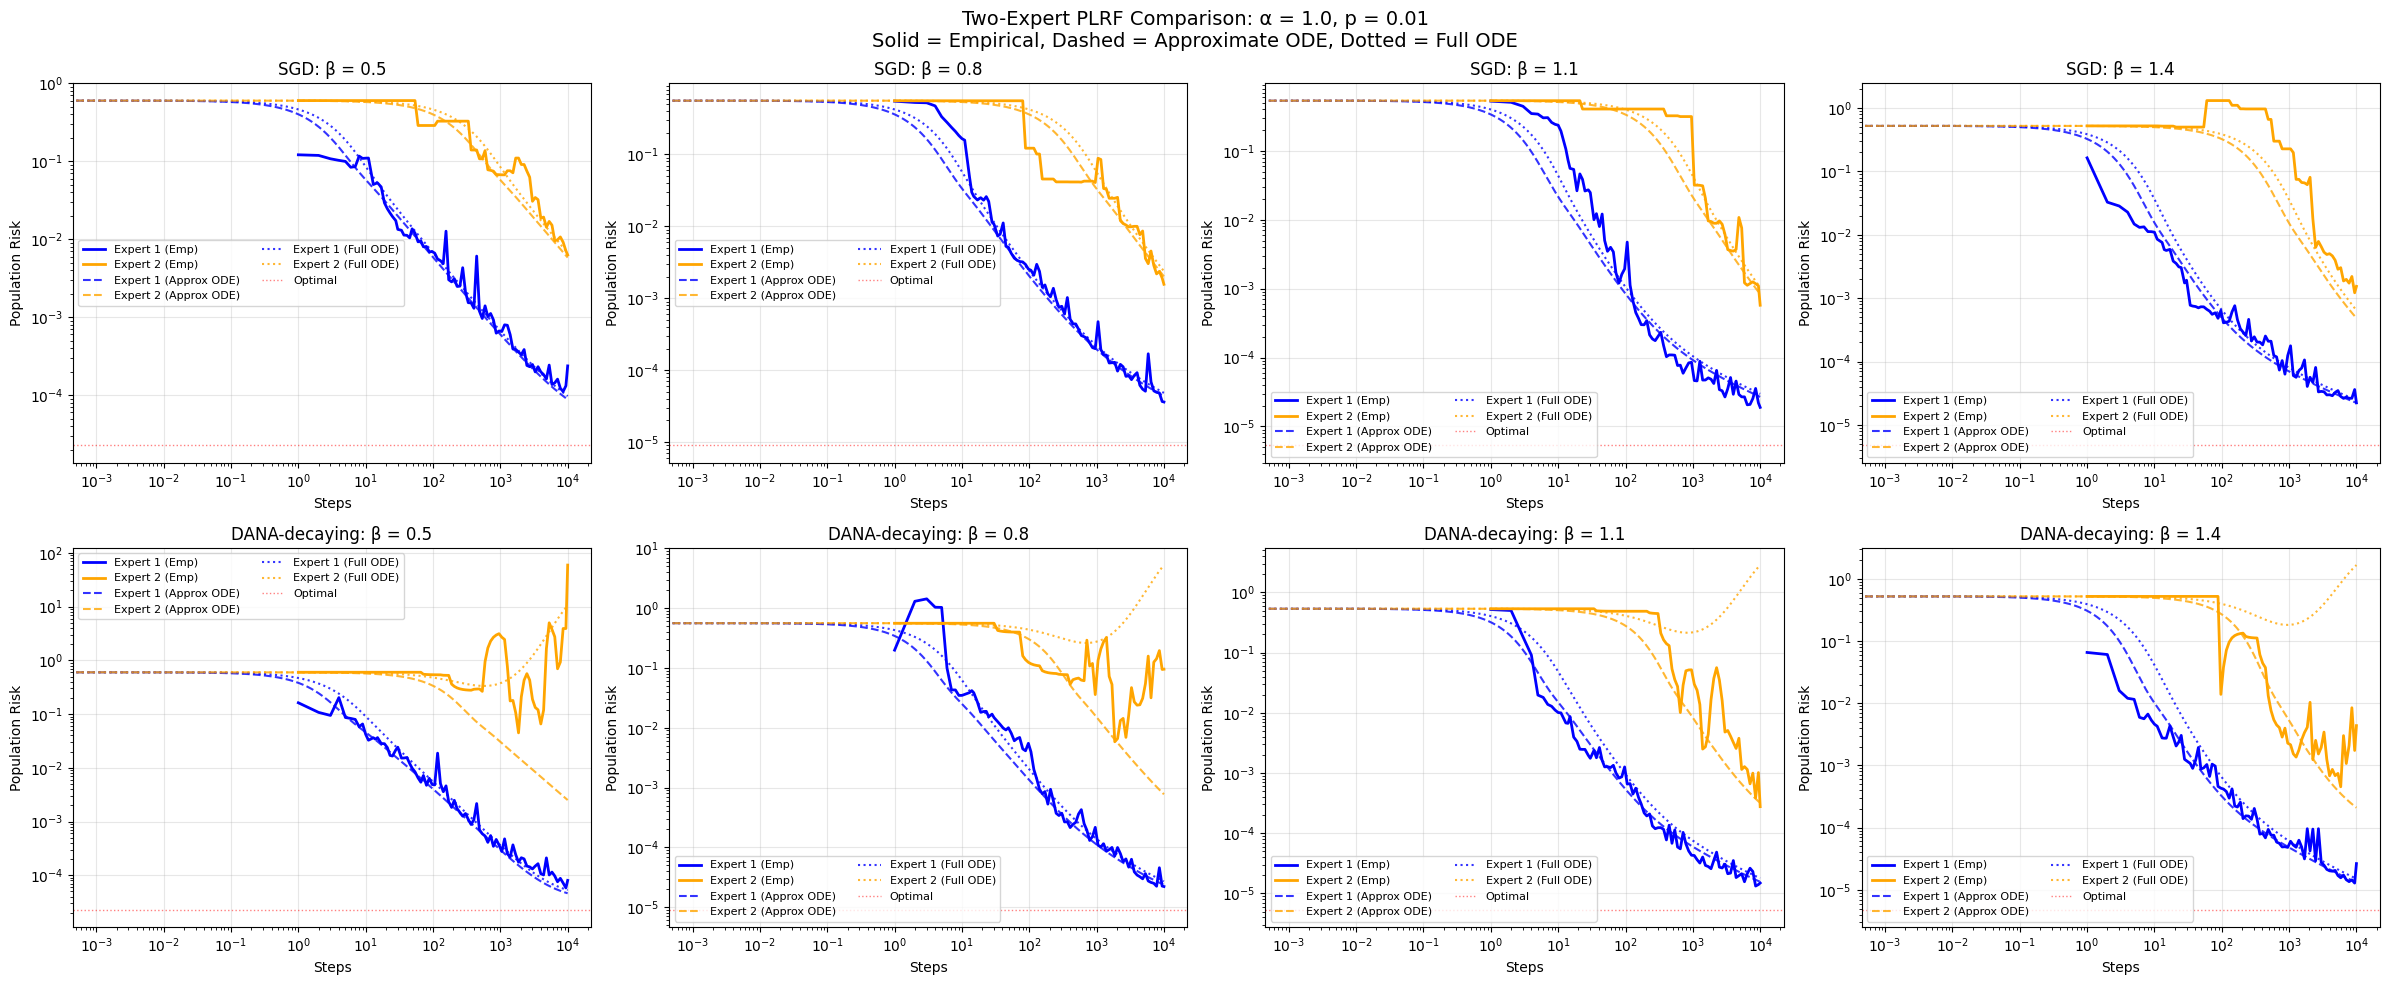

In [31]:
#@title Part 3: Visualization - All Results on Same Axes
"""
Create comparison plots with empirical, approximate ODE, and full ODE on the same axes.
"""

# Create figure with better layout
fig, axes = plt.subplots(2, len(BETA_LIST), figsize=(6*len(BETA_LIST), 10))
if len(BETA_LIST) == 1:
    axes = axes.reshape(2, 1)

# Define consistent colors and styles
expert1_color = 'blue'
expert2_color = 'orange'
optimal_color = 'red'

# Line styles
empirical_style = '-'      # Solid
approx_ode_style = '--'    # Dashed
full_ode_style = ':'       # Dotted

for idx, ode_result in enumerate(two_expert_ode_results):
    beta = ode_result['beta']

    # Try to get empirical results if available
    emp_result = two_expert_results[idx] if idx < len(two_expert_results) else None

    # Top row: SGD
    ax = axes[0, idx]

    # Plot empirical results if available
    if emp_result is not None:
        timestamps = emp_result['sgd']['timestamps']
        ax.loglog(timestamps[1:], emp_result['sgd']['per_expert_losses'][0][1:],
                  color=expert1_color, linestyle=empirical_style,
                  label='Expert 1 (Emp)', linewidth=2)
        ax.loglog(timestamps[1:], emp_result['sgd']['per_expert_losses'][1][1:],
                  color=expert2_color, linestyle=empirical_style,
                  label='Expert 2 (Emp)', linewidth=2)
        optimal_risk = emp_result['model'].optimal_risk()
    else:
        # If no empirical results, estimate optimal risk
        optimal_risk = theory.theory_limit_loss(ALPHA, beta, V, D)

    # Plot approximate ODE
    ode_times_approx = ode_result['sgd']['approx']['times']
    ax.loglog(ode_times_approx, ode_result['sgd']['approx']['expert_risks'][:, 0],
              color=expert1_color, linestyle=approx_ode_style,
              label='Expert 1 (Approx ODE)', linewidth=1.5, alpha=0.8)
    ax.loglog(ode_times_approx, ode_result['sgd']['approx']['expert_risks'][:, 1],
              color=expert2_color, linestyle=approx_ode_style,
              label='Expert 2 (Approx ODE)', linewidth=1.5, alpha=0.8)

    # Plot full ODE
    ode_times_full = ode_result['sgd']['full']['times']
    ax.loglog(ode_times_full, ode_result['sgd']['full']['expert_risks'][:, 0],
              color=expert1_color, linestyle=full_ode_style,
              label='Expert 1 (Full ODE)', linewidth=1.5, alpha=0.8)
    ax.loglog(ode_times_full, ode_result['sgd']['full']['expert_risks'][:, 1],
              color=expert2_color, linestyle=full_ode_style,
              label='Expert 2 (Full ODE)', linewidth=1.5, alpha=0.8)

    # Add optimal line
    ax.axhline(y=optimal_risk, color=optimal_color, linestyle=':',
               label='Optimal', alpha=0.5, linewidth=1)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'SGD: β = {beta}')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

    # Bottom row: DANA decaying
    ax = axes[1, idx]

    # Plot empirical results if available
    if emp_result is not None:
        ax.loglog(timestamps[1:], emp_result['dana_decaying']['per_expert_losses'][0][1:],
                  color=expert1_color, linestyle=empirical_style,
                  label='Expert 1 (Emp)', linewidth=2)
        ax.loglog(timestamps[1:], emp_result['dana_decaying']['per_expert_losses'][1][1:],
                  color=expert2_color, linestyle=empirical_style,
                  label='Expert 2 (Emp)', linewidth=2)

    # Plot approximate ODE
    ode_times_approx = ode_result['dana_decaying']['approx']['times']
    ax.loglog(ode_times_approx, ode_result['dana_decaying']['approx']['expert_risks'][:, 0],
              color=expert1_color, linestyle=approx_ode_style,
              label='Expert 1 (Approx ODE)', linewidth=1.5, alpha=0.8)
    ax.loglog(ode_times_approx, ode_result['dana_decaying']['approx']['expert_risks'][:, 1],
              color=expert2_color, linestyle=approx_ode_style,
              label='Expert 2 (Approx ODE)', linewidth=1.5, alpha=0.8)

    # Plot full ODE
    ode_times_full = ode_result['dana_decaying']['full']['times']
    ax.loglog(ode_times_full, ode_result['dana_decaying']['full']['expert_risks'][:, 0],
              color=expert1_color, linestyle=full_ode_style,
              label='Expert 1 (Full ODE)', linewidth=1.5, alpha=0.8)
    ax.loglog(ode_times_full, ode_result['dana_decaying']['full']['expert_risks'][:, 1],
              color=expert2_color, linestyle=full_ode_style,
              label='Expert 2 (Full ODE)', linewidth=1.5, alpha=0.8)

    # Add optimal line
    ax.axhline(y=optimal_risk, color=optimal_color, linestyle=':',
               label='Optimal', alpha=0.5, linewidth=1)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'DANA-decaying: β = {beta}')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

# Add main title with parameters
plt.suptitle(f'Two-Expert PLRF Comparison: α = {ALPHA}, p = {P}\n'
             f'Solid = Empirical, Dashed = Approximate ODE, Dotted = Full ODE',
             fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
#@title Part 4: General MoE with Power-Law Expert Selection
"""
Test the general MoE model with power-law expert selection using SGD and DANA-decaying.
"""

print("\n" + "="*60)
print(f"General MoE PLRF: {M} Experts with Power-Law Selection")
print("="*60)

moe_results = []

for beta in BETA_LIST:
    print(f"\nRunning MoE experiments for β = {beta}")

    # Create MoE model
    key, model_key = random.split(key)
    model = MixtureOfExpertsPLRF(
        alpha=ALPHA,
        beta=beta,
        v=V,
        d=D,
        m=M,
        zeta=ZETA,
        key=model_key
    )

    print(f"  Expert probabilities: {model.expert_probs}")
    print(f"  Optimal risk: {model.population_risk(model.optimal_params_per_expert()):.6f}")

    # Create hyperparameters using the same helper functions
    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    sgd_opt = dana_optimizer(sgd_hparams.g1, sgd_hparams.g2, sgd_hparams.g3, sgd_hparams.delta)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_decaying_opt = dana_optimizer(dana_decaying_hparams.g1, dana_decaying_hparams.g2, dana_decaying_hparams.g3, dana_decaying_hparams.delta)

    # SGD experiment
    sgd_trainer = MoEPLRFTrainer(model, sgd_opt)
    key, train_key = random.split(key)
    sgd_results = sgd_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    # DANA-decaying experiment
    dana_decaying_trainer = MoEPLRFTrainer(model, dana_decaying_opt)
    key, train_key = random.split(key)
    dana_decaying_results = dana_decaying_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    moe_results.append({
        'beta': beta,
        'model': model,
        'sgd': sgd_results,
        'dana_decaying': dana_decaying_results
    })




General MoE PLRF: 12 Experts with Power-Law Selection

Running MoE experiments for β = 0.5
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000025


100%|██████████| 10000/10000 [00:10<00:00, 982.57it/s]



Running MoE experiments for β = 0.8
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000008


100%|██████████| 10000/10000 [00:09<00:00, 1044.24it/s]



Running MoE experiments for β = 1.1
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000006


100%|██████████| 10000/10000 [00:10<00:00, 984.82it/s]



Running MoE experiments for β = 1.4
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000004


100%|██████████| 10000/10000 [00:09<00:00, 1090.41it/s]


In [33]:
#@title Part 5: ODE Predictions for General MoE
"""
Compute ODE predictions for the general MoE model using SGD and DANA-decaying.
"""

print("\n" + "="*60)
print("Computing MoE ODE Predictions")
print("="*60)

moe_ode_results = []

for moe_result in moe_results:
    beta = moe_result['beta']
    model = moe_result['model']

    print(f"\nComputing MoE ODE for β = {beta}")

    # Get theoretical initialization
    fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, D)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    risk_infty_theory = theory.theory_limit_loss(ALPHA, beta, V, D)

    # Create ODE inputs
    ode_inputs = MoEODEInputs(
        eigs_K=fake_eigs,
        rho_init=rho_init,
        chi_init=chi_init,
        sigma_init=sigma_init,
        risk_infinity=risk_infty_theory,
        expert_probs=model.expert_probs
    )

    # Use the same hyperparameters as in the empirical experiments
    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)

    # Run ODE for SGD
    ode_times_sgd, expert_risks_sgd, total_risk_sgd = ode_moe_dana_log_implicit(
        ode_inputs,
        sgd_hparams,
        batch=BATCH_SIZE,
        D=D,
        m=M,
        t_max=STEPS,
        dt=DT,
        approximate=True
    )

    # Run ODE for DANA-decaying
    ode_times_dana_decaying, expert_risks_dana_decaying, total_risk_dana_decaying = ode_moe_dana_log_implicit(
        ode_inputs,
        dana_decaying_hparams,
        batch=BATCH_SIZE,
        D=D,
        m=M,
        t_max=STEPS,
        dt=DT,
        approximate=True
    )

    moe_ode_results.append({
        'beta': beta,
        'sgd': {
            'times': ode_times_sgd,
            'expert_risks': expert_risks_sgd / 2,  # Convert to actual risk
            'total_risk': total_risk_sgd / 2
        },
        'dana_decaying': {
            'times': ode_times_dana_decaying,
            'expert_risks': expert_risks_dana_decaying / 2,
            'total_risk': total_risk_dana_decaying / 2
        }
    })




Computing MoE ODE Predictions

Computing MoE ODE for β = 0.5

Computing MoE ODE for β = 0.8

Computing MoE ODE for β = 1.1

Computing MoE ODE for β = 1.4


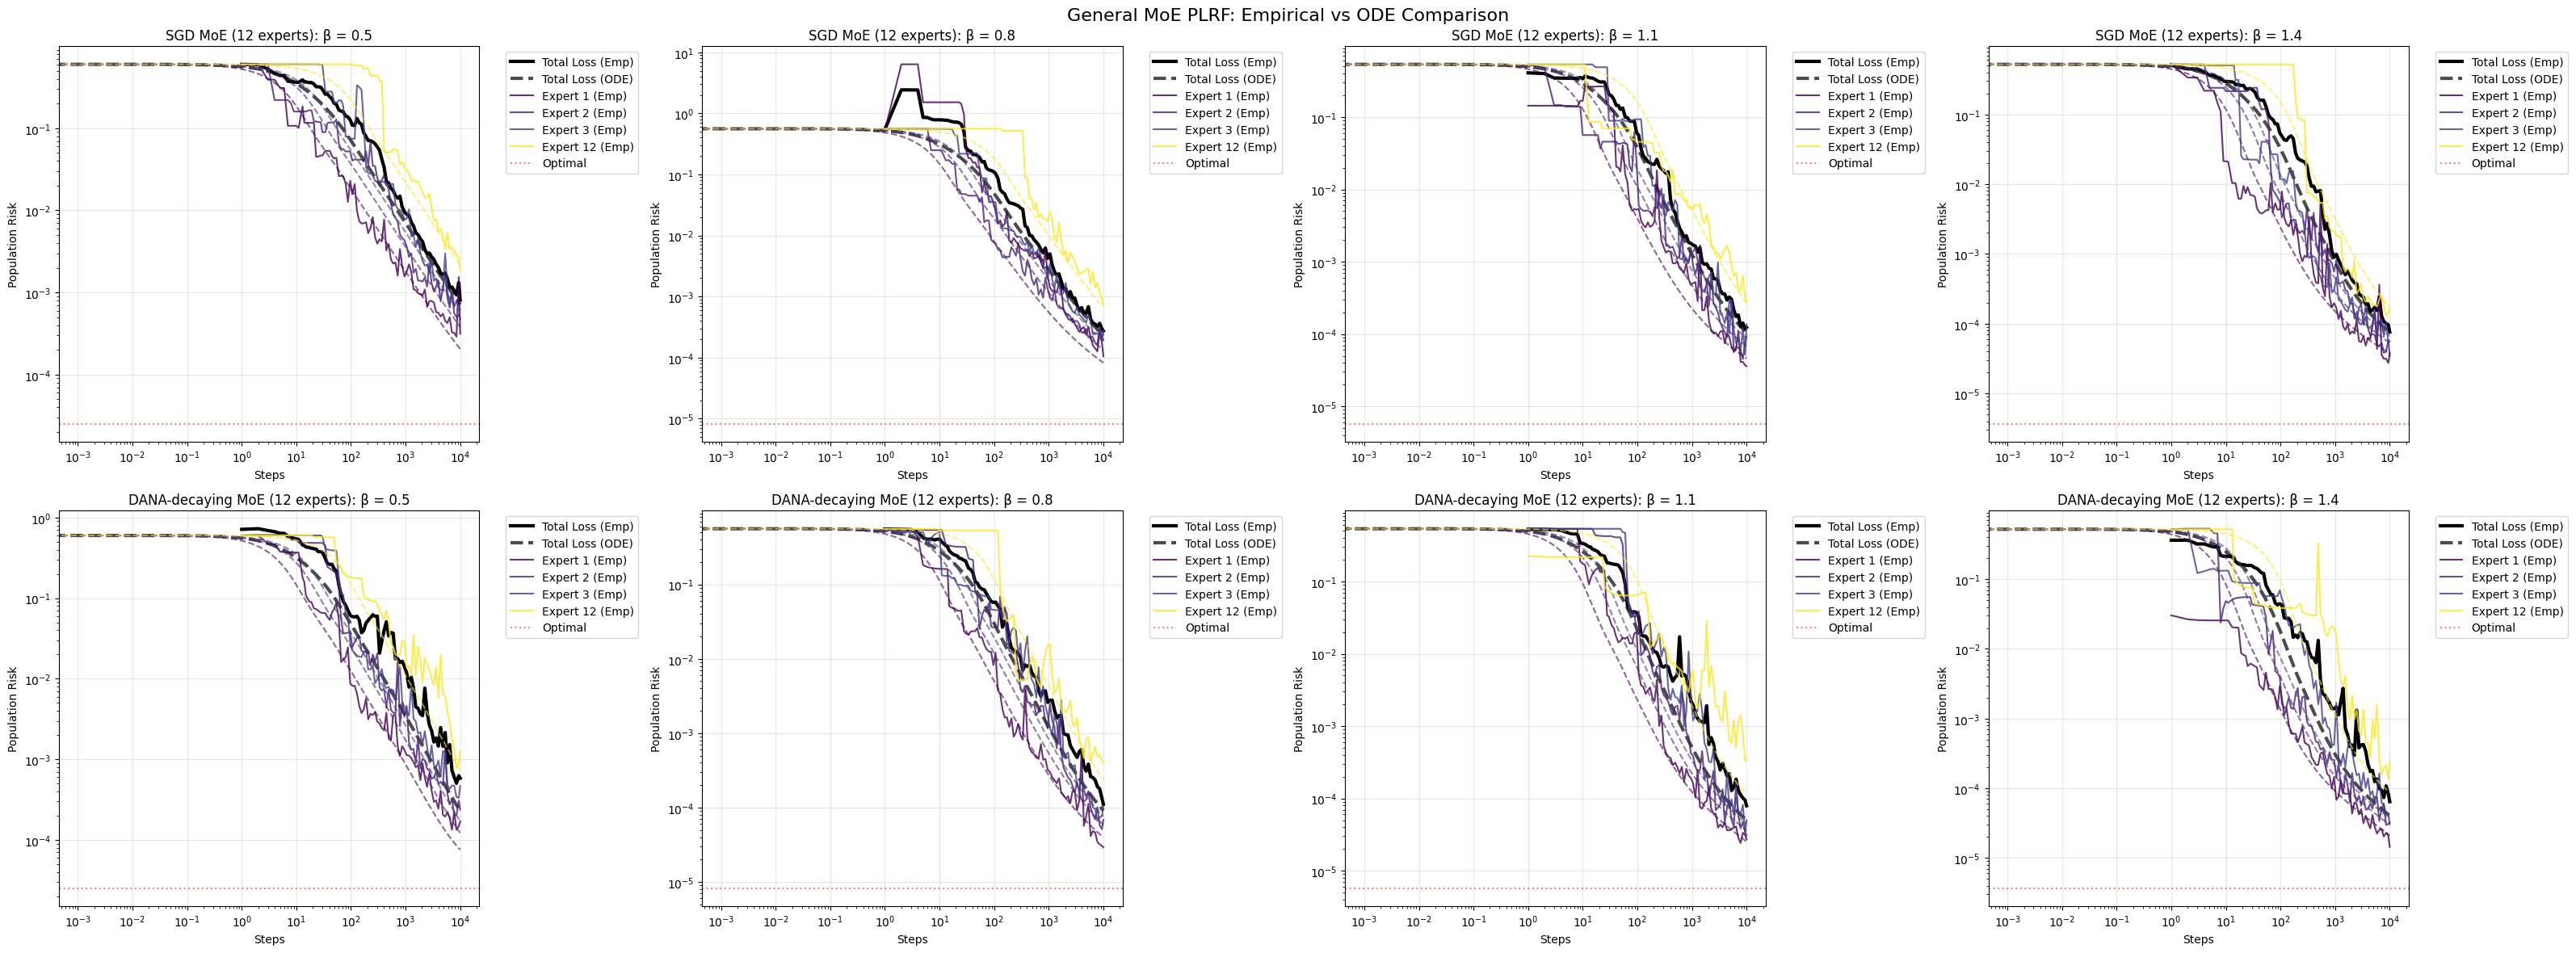

In [34]:
#@title Part 6: Visualization - General MoE Results
"""
Visualize general MoE results with ODE comparison for both SGD and DANA-decaying.
"""

fig, axes = plt.subplots(2, len(moe_results), figsize=(8*len(moe_results), 12))
if len(moe_results) == 1:
    axes = axes.reshape(2, 1)

for idx, (emp_result, ode_result) in enumerate(zip(moe_results, moe_ode_results)):
    beta = emp_result['beta']

    # Top row: SGD comparison
    ax = axes[0, idx]

    # Plot total loss comparison
    timestamps = emp_result['sgd']['timestamps']
    ax.loglog(timestamps[1:], emp_result['sgd']['losses'][1:],
              'k-', label='Total Loss (Emp)', linewidth=3)

    ode_times = ode_result['sgd']['times']
    ax.loglog(ode_times, ode_result['sgd']['total_risk'],
              'k--', label='Total Loss (ODE)', linewidth=3, alpha=0.7)

    # Plot per-expert losses (only show a subset for clarity)
    colors = plt.cm.viridis(np.linspace(0, 1, M))
    # Show only first 3 and last expert to avoid overcrowding
    experts_to_show = list(range(min(3, M))) + [M-1] if M > 4 else range(M)

    for i in experts_to_show:
        ax.loglog(timestamps[1:], emp_result['sgd']['per_expert_losses'][i][1:],
                  color=colors[i], label=f'Expert {i+1} (Emp)', linewidth=1.5, alpha=0.8)
        ax.loglog(ode_times, ode_result['sgd']['expert_risks'][:, i],
                  color=colors[i], linestyle='--', alpha=0.6, linewidth=1.5)

    ax.axhline(y=emp_result['model'].optimal_risk(), color='red',
               linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'SGD MoE ({M} experts): β = {beta}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # Bottom row: DANA-decaying comparison
    ax = axes[1, idx]

    # Plot total loss comparison
    ax.loglog(timestamps[1:], emp_result['dana_decaying']['losses'][1:],
              'k-', label='Total Loss (Emp)', linewidth=3)

    ax.loglog(ode_times, ode_result['dana_decaying']['total_risk'],
              'k--', label='Total Loss (ODE)', linewidth=3, alpha=0.7)

    # Plot per-expert losses
    for i in experts_to_show:
        ax.loglog(timestamps[1:], emp_result['dana_decaying']['per_expert_losses'][i][1:],
                  color=colors[i], label=f'Expert {i+1} (Emp)', linewidth=1.5, alpha=0.8)
        ax.loglog(ode_times, ode_result['dana_decaying']['expert_risks'][:, i],
                  color=colors[i], linestyle='--', alpha=0.6, linewidth=1.5)

    ax.axhline(y=emp_result['model'].optimal_risk(), color='red',
               linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'DANA-decaying MoE ({M} experts): β = {beta}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'General MoE PLRF: Empirical vs ODE Comparison', fontsize=16)
plt.tight_layout()
plt.show()



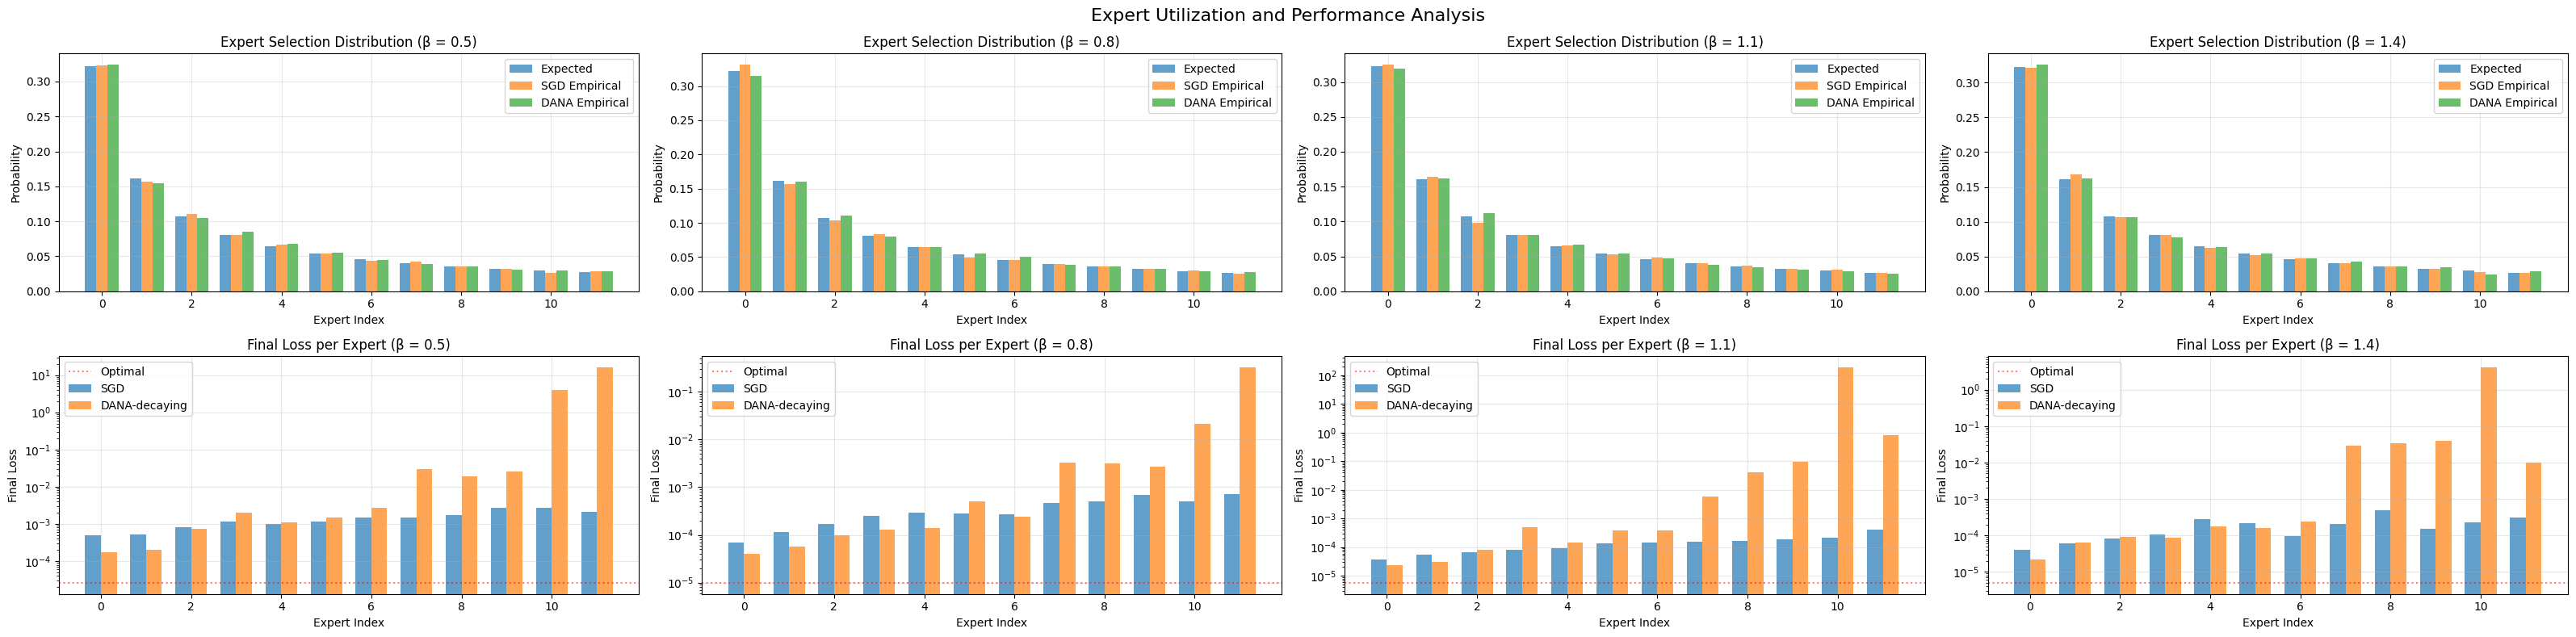


EXPERIMENT SUMMARY

Two-Expert Results:

β = 0.5:
  SGD final loss: 0.000367 (gap: 0.000338)
  DANA-decaying final loss: 0.000131 (gap: 0.000102)
  Expert 1 final (SGD): 0.000293
  Expert 2 final (SGD): 0.001031
  Expert 1 final (DANA): 0.000072
  Expert 2 final (DANA): 0.000667

β = 0.8:
  SGD final loss: 0.000104 (gap: 0.000094)
  DANA-decaying final loss: 0.000068 (gap: 0.000059)
  Expert 1 final (SGD): 0.000077
  Expert 2 final (SGD): 0.000345
  Expert 1 final (DANA): 0.000033
  Expert 2 final (DANA): 0.000380

β = 1.1:
  SGD final loss: 0.000031 (gap: 0.000026)
  DANA-decaying final loss: 0.000022 (gap: 0.000017)
  Expert 1 final (SGD): 0.000026
  Expert 2 final (SGD): 0.000079
  Expert 1 final (DANA): 0.000015
  Expert 2 final (DANA): 0.000090

β = 1.4:
  SGD final loss: 0.000025 (gap: 0.000020)
  DANA-decaying final loss: 0.000015 (gap: 0.000010)
  Expert 1 final (SGD): 0.000019
  Expert 2 final (SGD): 0.000080
  Expert 1 final (DANA): 0.000013
  Expert 2 final (DANA): 0.000038

In [ ]:
#@title Part 7: Expert Utilization Analysis
"""
Analyze how different experts are utilized during training for both SGD and DANA-decaying.
"""

fig, axes = plt.subplots(2, len(moe_results), figsize=(8*len(moe_results), 8))
if len(moe_results) == 1:
    axes = axes.reshape(2, 1)

for idx, emp_result in enumerate(moe_results):
    beta = emp_result['beta']
    model = emp_result['model']

    # Top: Sample distribution comparison (SGD vs DANA-decaying)
    ax = axes[0, idx]

    sgd_empirical_probs = emp_result['sgd']['expert_sample_counts'] / np.sum(emp_result['sgd']['expert_sample_counts'])
    dana_empirical_probs = emp_result['dana_decaying']['expert_sample_counts'] / np.sum(emp_result['dana_decaying']['expert_sample_counts'])

    x = np.arange(M)
    width = 0.25
    ax.bar(x - width, model.expert_probs, width, label='Expected', alpha=0.7)
    ax.bar(x, sgd_empirical_probs, width, label='SGD Empirical', alpha=0.7)
    ax.bar(x + width, dana_empirical_probs, width, label='DANA Empirical', alpha=0.7)
    ax.set_xlabel('Expert Index')
    ax.set_ylabel('Probability')
    ax.set_title(f'Expert Selection Distribution (β = {beta})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Bottom: Final loss per expert comparison
    ax = axes[1, idx]

    sgd_final_losses = [emp_result['sgd']['per_expert_losses'][i][-1] for i in range(M)]
    dana_final_losses = [emp_result['dana_decaying']['per_expert_losses'][i][-1] for i in range(M)]

    x = np.arange(M)
    width = 0.35
    ax.bar(x - width/2, sgd_final_losses, width, label='SGD', alpha=0.7)
    ax.bar(x + width/2, dana_final_losses, width, label='DANA-decaying', alpha=0.7)
    ax.axhline(y=model.optimal_risk(), color='red', linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Expert Index')
    ax.set_ylabel('Final Loss')
    ax.set_title(f'Final Loss per Expert (β = {beta})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.suptitle('Expert Utilization and Performance Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#@title Summary
print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

print("\nTwo-Expert Results:")
for emp_result in two_expert_results:
    beta = emp_result['beta']
    final_sgd = emp_result['sgd']['losses'][-1]
    final_dana = emp_result['dana_decaying']['losses'][-1]
    optimal = emp_result['model'].optimal_risk()

    print(f"\nβ = {beta}:")
    print(f"  SGD final loss: {final_sgd:.6f} (gap: {final_sgd - optimal:.6f})")
    print(f"  DANA-decaying final loss: {final_dana:.6f} (gap: {final_dana - optimal:.6f})")
    print(f"  Expert 1 final (SGD): {emp_result['sgd']['per_expert_losses'][0][-1]:.6f}")
    print(f"  Expert 2 final (SGD): {emp_result['sgd']['per_expert_losses'][1][-1]:.6f}")
    print(f"  Expert 1 final (DANA): {emp_result['dana_decaying']['per_expert_losses'][0][-1]:.6f}")
    print(f"  Expert 2 final (DANA): {emp_result['dana_decaying']['per_expert_losses'][1][-1]:.6f}")

print("\n\nGeneral MoE Results:")
for emp_result in moe_results:
    beta = emp_result['beta']
    final_sgd = emp_result['sgd']['losses'][-1]
    final_dana = emp_result['dana_decaying']['losses'][-1]
    optimal = emp_result['model'].optimal_risk()

    print(f"\nβ = {beta}:")
    print(f"  SGD final loss: {final_sgd:.6f} (gap: {final_sgd - optimal:.6f})")
    print(f"  DANA-decaying final loss: {final_dana:.6f} (gap: {final_dana - optimal:.6f})")

    # Expert utilization
    sgd_utilization = emp_result['sgd']['expert_sample_counts'] / np.sum(emp_result['sgd']['expert_sample_counts'])
    dana_utilization = emp_result['dana_decaying']['expert_sample_counts'] / np.sum(emp_result['dana_decaying']['expert_sample_counts'])

    print(f"  Expert utilization (SGD):", np.round(sgd_utilization, 3))
    print(f"  Expert utilization (DANA):", np.round(dana_utilization, 3))

print("\n" + "="*60)
print("Experiment complete!")

# Debugging

Test 1: DANA-decaying on single expert PLRF


100%|██████████| 5000/5000 [00:05<00:00, 893.73it/s]


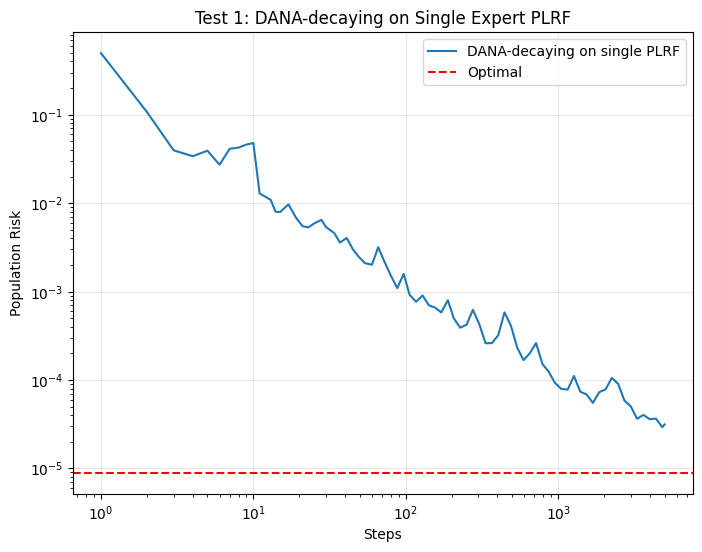


Test 2: Two-expert PLRF with detailed diagnostics
Step 0: Train loss = 0.000029, Pop loss = 0.557883
Step 1000: Train loss = 0.000244, Pop loss = 0.000225
Step 2000: Train loss = 0.000054, Pop loss = 0.000242
Step 3000: Train loss = 0.000037, Pop loss = 0.000213
Step 4000: Train loss = 0.000014, Pop loss = 0.000056


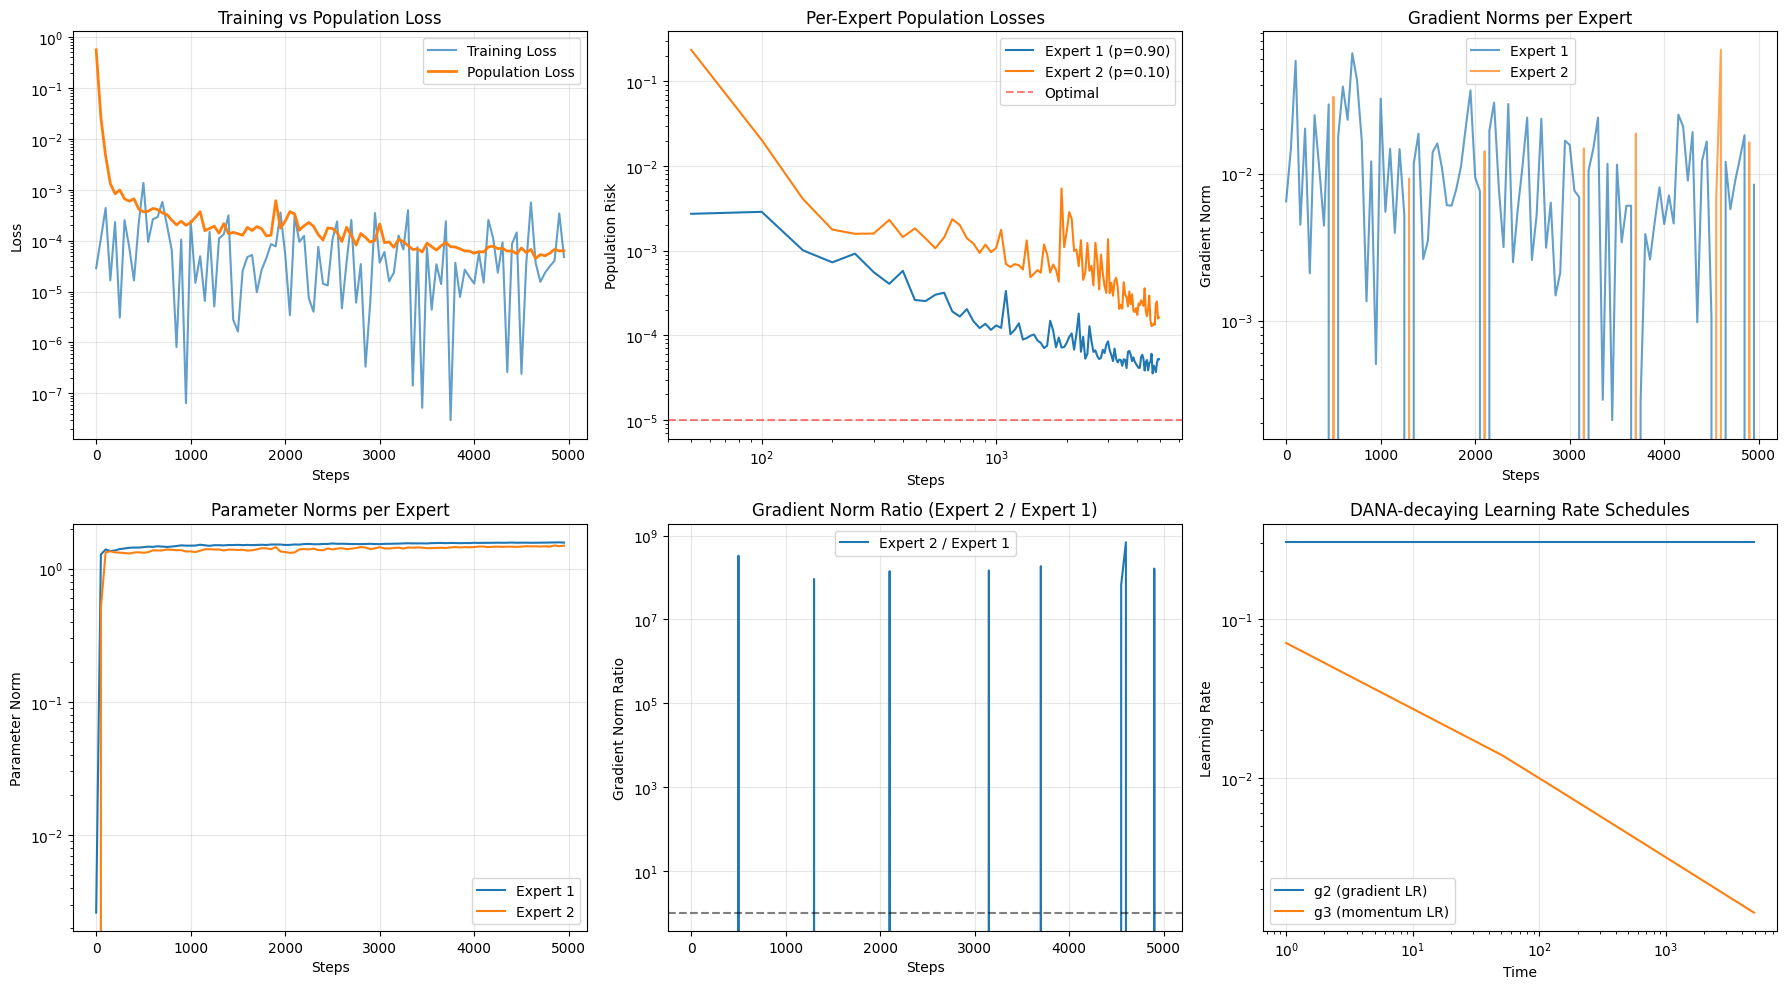


Diagnostic Summary:
Final population loss: 0.000063
Final training loss: 0.000048
Expert 1 final loss: 0.000052
Expert 2 final loss: 0.000162
Max gradient norm - Expert 1: 0.065648
Max gradient norm - Expert 2: 0.069295


In [ ]:
# debug_dana_moe.py
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import matplotlib.pyplot as plt
from typing import Dict, Tuple
import numpy as np

# Import the implementations
from power_law_rf.moe_plrf.moe_plrf import (
    PowerLawRandomFeatures, PLRFTrainer, TwoExpertPLRF, MoEPLRFTrainer
)
from power_law_rf.optimizers import powerlaw_schedule, dana_optimizer

# Set up parameters
ALPHA = 1.0
BETA = 0.8
V = 2000
D = 500
BATCH_SIZE = 1
STEPS = 5000
P = 0.1  # Expert 2 probability

# Helper functions from the test notebook
def get_traceK(alpha, v):
    x_grid = jnp.arange(1, v+1).reshape(1, v)
    population_eigs = x_grid ** -alpha
    population_trace = jnp.sum(population_eigs**2)
    return population_trace

def get_dana_decaying_hparams(alpha, beta, d, batch_size, g2_scale, g3_iv, traceK):
    learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
    g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1.0)
    g2 = powerlaw_schedule(learning_rate, 0.0, 0.0, 1.0)
    g3 = powerlaw_schedule(g3_iv, 0.0, -(1.0) / (2 * alpha), 1.0)
    delta = powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(alpha+beta)/(2*alpha))
    return g1, g2, g3, delta

# Modified trainer to track training losses and gradients
class DebugMoEPLRFTrainer(MoEPLRFTrainer):
    def train_with_diagnostics(self,
                               key: random.PRNGKey,
                               num_steps: int,
                               batch_size: int,
                               init_params=None,
                               eval_freq=100) -> Dict:
        """Modified training that tracks additional diagnostics."""

        if init_params is None:
            init_params = jnp.zeros((self.model.d, self.model.m))

        params = init_params
        opt_state = self.optimizer.init(params)

        # Storage for diagnostics
        diagnostics = {
            'timestamps': [],
            'population_losses': [],
            'training_losses': [],
            'grad_norms': {i: [] for i in range(self.model.m)},
            'param_norms': {i: [] for i in range(self.model.m)},
            'per_expert_pop_losses': {i: [] for i in range(self.model.m)}
        }

        @jax.jit
        def compute_moe_gradients_debug(params, X, y, expert_indices):
            """Compute gradients and return additional info."""
            R = self.model.create_routing_matrix(expert_indices, batch_size)
            samples_per_expert = jnp.sum(R, axis=1)

            def loss_fn(params):
                all_predictions = jnp.matmul(X, params)
                predictions = jnp.sum(all_predictions * R.T, axis=1)
                return jnp.mean(optax.l2_loss(predictions, y))

            loss_val, grads = jax.value_and_grad(loss_fn)(params)

            # Compute per-expert gradient norms
            grad_norms = jnp.array([jnp.linalg.norm(grads[:, i]) for i in range(self.model.m)])

            return grads, samples_per_expert, loss_val, grad_norms

        @jax.jit
        def train_step_debug(params, opt_state, key):
            key_data, key_expert = random.split(key)
            X, y = self.model.generate_batch(key_data, batch_size)
            expert_indices = self.model.sample_expert_batch(key_expert, batch_size)

            grads, samples_per_expert, train_loss, grad_norms = compute_moe_gradients_debug(
                params, X, y, expert_indices
            )

            updates, opt_state = self.optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)

            return params, opt_state, train_loss, grad_norms, samples_per_expert

        # Training loop
        for step in range(num_steps):
            key, subkey = random.split(key)

            params, opt_state, train_loss, grad_norms, samples_per_expert = train_step_debug(
                params, opt_state, subkey
            )

            # Record diagnostics every eval_freq steps
            if step % eval_freq == 0:
                diagnostics['timestamps'].append(step)
                diagnostics['training_losses'].append(float(train_loss))
                diagnostics['population_losses'].append(float(self.model.population_risk(params)))

                for i in range(self.model.m):
                    diagnostics['grad_norms'][i].append(float(grad_norms[i]))
                    diagnostics['param_norms'][i].append(float(jnp.linalg.norm(params[:, i])))
                    expert_risk = super(type(self.model), self.model).population_risk(params[:, i])
                    diagnostics['per_expert_pop_losses'][i].append(float(expert_risk))

                # Print progress
                if step % 1000 == 0:
                    print(f"Step {step}: Train loss = {train_loss:.6f}, "
                          f"Pop loss = {diagnostics['population_losses'][-1]:.6f}")

        # Convert lists to arrays
        for key in ['timestamps', 'population_losses', 'training_losses']:
            diagnostics[key] = jnp.array(diagnostics[key])

        for i in range(self.model.m):
            for key in ['grad_norms', 'param_norms', 'per_expert_pop_losses']:
                diagnostics[key][i] = jnp.array(diagnostics[key][i])

        diagnostics['final_params'] = params
        return diagnostics

# Test 1: DANA-decaying on single expert PLRF
print("=" * 60)
print("Test 1: DANA-decaying on single expert PLRF")
print("=" * 60)

key = random.PRNGKey(42)
key, model_key = random.split(key)

# Create single expert model
single_model = PowerLawRandomFeatures(
    alpha=ALPHA, beta=BETA, v=V, d=D, key=model_key
)

# Create DANA-decaying optimizer
traceK = get_traceK(ALPHA, V)
g1, g2, g3, delta = get_dana_decaying_hparams(ALPHA, BETA, D, BATCH_SIZE, 0.5, 0.1, traceK)
dana_opt = dana_optimizer(g1, g2, g3, delta)

# Train single expert
trainer = PLRFTrainer(single_model, dana_opt)
key, train_key = random.split(key)
timestamps, losses = trainer.train(train_key, num_steps=STEPS, batch_size=BATCH_SIZE)

plt.figure(figsize=(8, 6))
plt.loglog(timestamps[1:], losses[1:], label='DANA-decaying on single PLRF')
plt.axhline(y=single_model.optimal_risk(), color='r', linestyle='--', label='Optimal')
plt.xlabel('Steps')
plt.ylabel('Population Risk')
plt.title('Test 1: DANA-decaying on Single Expert PLRF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Test 2: Two-expert model with diagnostics
print("\n" + "=" * 60)
print("Test 2: Two-expert PLRF with detailed diagnostics")
print("=" * 60)

key, model_key = random.split(key)
two_expert_model = TwoExpertPLRF(
    alpha=ALPHA, beta=BETA, v=V, d=D, p=P, key=model_key
)

# Create DANA-decaying optimizer
dana_opt = dana_optimizer(g1, g2, g3, delta)

# Train with diagnostics
debug_trainer = DebugMoEPLRFTrainer(two_expert_model, dana_opt)
key, train_key = random.split(key)
diagnostics = debug_trainer.train_with_diagnostics(
    train_key, num_steps=STEPS, batch_size=BATCH_SIZE, eval_freq=50
)

# Plot diagnostics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Training vs population loss
ax = axes[0, 0]
ax.semilogy(diagnostics['timestamps'], diagnostics['training_losses'],
            label='Training Loss', alpha=0.7)
ax.semilogy(diagnostics['timestamps'], diagnostics['population_losses'],
            label='Population Loss', linewidth=2)
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.set_title('Training vs Population Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Per-expert population losses
ax = axes[0, 1]
for i in range(2):
    ax.loglog(diagnostics['timestamps'][1:],
              diagnostics['per_expert_pop_losses'][i][1:],
              label=f'Expert {i+1} (p={two_expert_model.expert_probs[i]:.2f})')
ax.axhline(y=two_expert_model.optimal_risk(), color='r', linestyle='--',
           label='Optimal', alpha=0.5)
ax.set_xlabel('Steps')
ax.set_ylabel('Population Risk')
ax.set_title('Per-Expert Population Losses')
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient norms
ax = axes[0, 2]
for i in range(2):
    ax.semilogy(diagnostics['timestamps'], diagnostics['grad_norms'][i],
                label=f'Expert {i+1}', alpha=0.7)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Norm')
ax.set_title('Gradient Norms per Expert')
ax.legend()
ax.grid(True, alpha=0.3)

# Parameter norms
ax = axes[1, 0]
for i in range(2):
    ax.semilogy(diagnostics['timestamps'], diagnostics['param_norms'][i],
                label=f'Expert {i+1}')
ax.set_xlabel('Steps')
ax.set_ylabel('Parameter Norm')
ax.set_title('Parameter Norms per Expert')
ax.legend()
ax.grid(True, alpha=0.3)

# Gradient norm ratio
ax = axes[1, 1]
ratio = diagnostics['grad_norms'][1] / (diagnostics['grad_norms'][0] + 1e-10)
ax.semilogy(diagnostics['timestamps'], ratio, label='Expert 2 / Expert 1')
ax.axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradient Norm Ratio')
ax.set_title('Gradient Norm Ratio (Expert 2 / Expert 1)')
ax.legend()
ax.grid(True, alpha=0.3)

# Learning rate schedule visualization
ax = axes[1, 2]
times = diagnostics['timestamps'] + 1  # Add 1 to avoid log(0)
lr_vals = [g2(t) for t in times]
momentum_lr_vals = [g3(t) for t in times]
ax.loglog(times, lr_vals, label='g2 (gradient LR)')
ax.loglog(times, momentum_lr_vals, label='g3 (momentum LR)')
ax.set_xlabel('Time')
ax.set_ylabel('Learning Rate')
ax.set_title('DANA-decaying Learning Rate Schedules')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
print("\nDiagnostic Summary:")
print(f"Final population loss: {diagnostics['population_losses'][-1]:.6f}")
print(f"Final training loss: {diagnostics['training_losses'][-1]:.6f}")
print(f"Expert 1 final loss: {diagnostics['per_expert_pop_losses'][0][-1]:.6f}")
print(f"Expert 2 final loss: {diagnostics['per_expert_pop_losses'][1][-1]:.6f}")
print(f"Max gradient norm - Expert 1: {np.max(diagnostics['grad_norms'][0]):.6f}")
print(f"Max gradient norm - Expert 2: {np.max(diagnostics['grad_norms'][1]):.6f}")

# Check for exploding values
for i in range(2):
    if np.any(np.isnan(diagnostics['per_expert_pop_losses'][i])) or \
       np.any(diagnostics['per_expert_pop_losses'][i] > 1e10):
        print(f"\nWARNING: Expert {i+1} has exploding losses!")
        first_bad = np.where(diagnostics['per_expert_pop_losses'][i] > 1e10)[0]
        if len(first_bad) > 0:
            print(f"  First explosion at step {diagnostics['timestamps'][first_bad[0]]}")

## Sparse Gradients PLRF


Testing with selection probability p = 1.0
Step 0: Loss = 0.235002, Param norm = 1.730542, Update norm = 1.730542

Testing with selection probability p = 0.5
Step 0: Loss = 0.103517, Param norm = 0.748579, Update norm = 0.748579

Testing with selection probability p = 0.1
Step 0: Loss = 0.557994, Param norm = 0.000000, Update norm = 0.000000

Testing with selection probability p = 0.05
Step 0: Loss = 0.557994, Param norm = 0.000000, Update norm = 0.000000

Testing with selection probability p = 0.01
Step 0: Loss = 0.557994, Param norm = 0.000000, Update norm = 0.000000

Testing with selection probability p = 0.002
Step 0: Loss = 0.557994, Param norm = 0.000000, Update norm = 0.000000


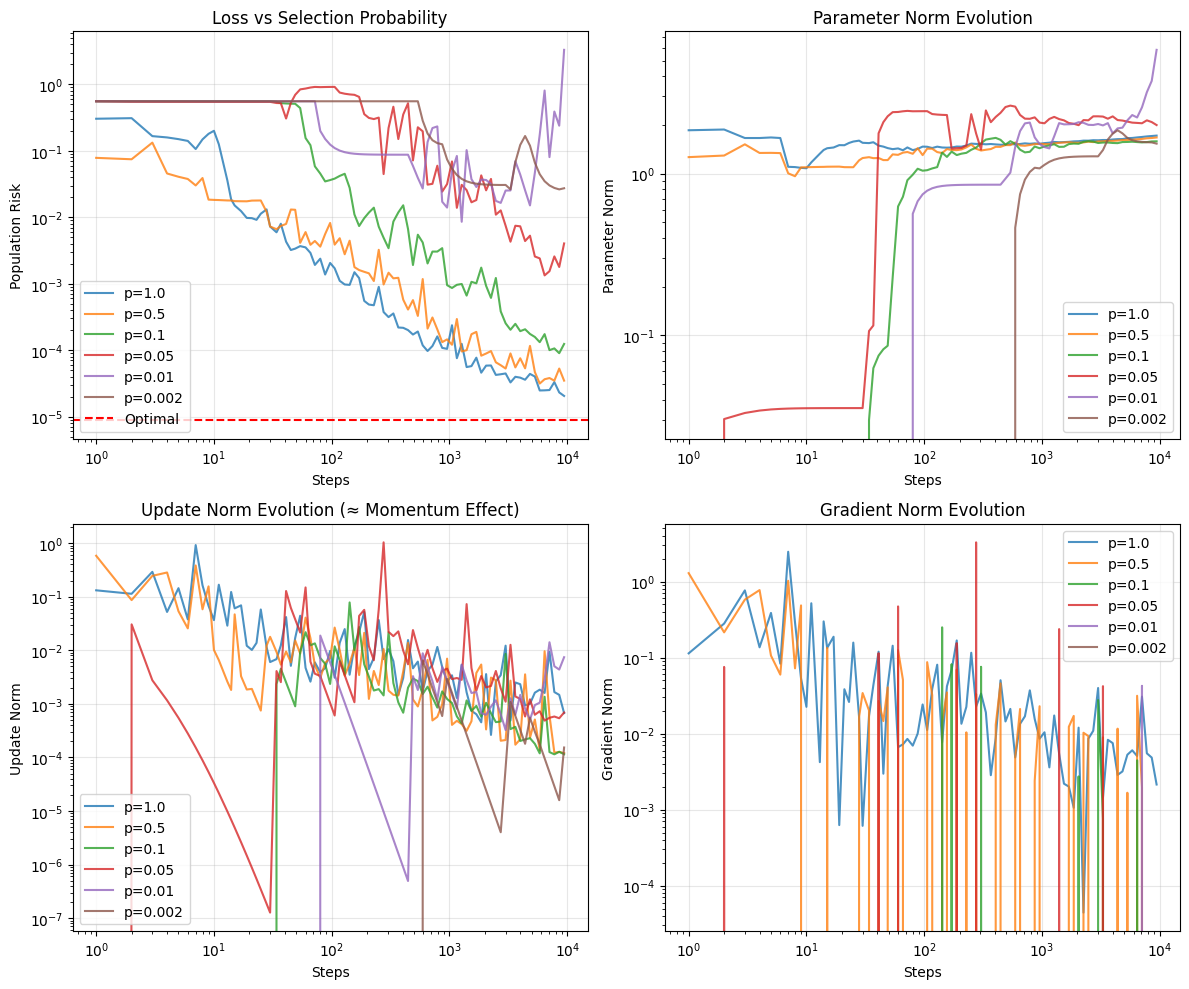

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import matplotlib.pyplot as plt

# Modified trainer that properly extracts momentum
class SparseGradientTrainerV2:
    def __init__(self, model, optimizer, selection_prob=1.0):
        self.model = model
        self.optimizer = optimizer
        self.selection_prob = selection_prob

    def train(self, key, num_steps, batch_size, init_params=None):
        if init_params is None:
            init_params = jnp.zeros(self.model.d)

        params = init_params
        opt_state = self.optimizer.init(params)

        # Track metrics
        losses = []
        param_norms = []
        momentum_data = []  # Store full momentum vectors
        gradient_norms = []
        selection_history = []

        eval_times = jnp.unique(jnp.concatenate([
            jnp.array([0]),
            jnp.int32(1.1 ** jnp.arange(1, jnp.ceil(jnp.log(num_steps) / jnp.log(1.1)))),
            jnp.array([num_steps])
        ]))

        @jax.jit
        def batch_loss(params, X, y):
            y_pred = jnp.matmul(X, params)
            return jnp.mean(optax.l2_loss(y_pred, y))

        # Non-jitted version to allow inspection of optimizer state
        def train_step_with_state(params, opt_state, key, apply_gradient):
            # Generate batch
            data_key, _ = random.split(key)
            X, y = self.model.generate_batch(data_key, batch_size)

            # Compute loss and gradients
            loss, grads = jax.value_and_grad(batch_loss)(params, X, y)

            # Zero out gradients based on selection
            grads = grads * apply_gradient

            # Update parameters and get new state
            updates, new_opt_state = self.optimizer.update(grads, opt_state, params)
            new_params = optax.apply_updates(params, updates)

            return new_params, new_opt_state, loss, grads, updates

        # Training loop
        eval_idx = 0
        next_eval = eval_times[eval_idx]

        for step in range(num_steps):
            # Determine if we apply gradient this step
            key, subkey, selection_key = random.split(key, 3)
            apply_gradient = random.uniform(selection_key) < self.selection_prob

            # Train step
            params, opt_state, batch_loss_val, grads, updates = train_step_with_state(
                params, opt_state, subkey, float(apply_gradient)
            )

            # Track selection
            selection_history.append(apply_gradient)

            # Evaluate if needed
            if step == next_eval:
                pop_loss = self.model.population_risk(params)
                losses.append(pop_loss)
                param_norms.append(float(jnp.linalg.norm(params)))
                gradient_norms.append(float(jnp.linalg.norm(grads)))

                # For DANA, the momentum is essentially the accumulated updates
                # We can track the update magnitude instead
                momentum_data.append(float(jnp.linalg.norm(updates)))

                eval_idx += 1
                if eval_idx < len(eval_times):
                    next_eval = eval_times[eval_idx]

                if step % 1000 == 0:
                    print(f"Step {step}: Loss = {pop_loss:.6f}, "
                          f"Param norm = {param_norms[-1]:.6f}, "
                          f"Update norm = {momentum_data[-1]:.6f}")

        return {
            'timestamps': eval_times[:eval_idx],
            'losses': jnp.array(losses),
            'param_norms': jnp.array(param_norms),
            'update_norms': jnp.array(momentum_data),  # This is more meaningful
            'gradient_norms': jnp.array(gradient_norms),
            'selection_rate': jnp.mean(jnp.array(selection_history))
        }

# Also, let's create a simple momentum tracking wrapper
class MomentumTrackingDANA:
    """Wrapper around DANA that explicitly tracks momentum."""
    def __init__(self, g1, g2, g3, delta):
        self.g1 = g1
        self.g2 = g2
        self.g3 = g3
        self.delta = delta

    def init(self, params):
        momentum = jnp.zeros_like(params)
        return {'momentum': momentum, 'step': 0}

    def update(self, grads, state, params):
        t = state['step'] + 1
        momentum = state['momentum']

        # DANA update rules
        new_momentum = (1 - self.delta(t)) * momentum + self.g1(t) * grads
        updates = -self.g2(t) * grads - self.g3(t) * new_momentum

        new_state = {'momentum': new_momentum, 'step': t}
        return updates, new_state

# Run experiment with better tracking
from power_law_rf.moe_plrf.moe_plrf import PowerLawRandomFeatures

key = random.PRNGKey(42)
key, model_key = random.split(key)
model = PowerLawRandomFeatures(alpha=ALPHA, beta=BETA, v=V, d=D, key=model_key)

# Test with custom DANA implementation for better visibility
selection_probs = [1.0, 0.5, 0.1, 0.05, 0.01, 0.002]
results = {}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for p in selection_probs:
    print(f"\nTesting with selection probability p = {p}")

    # Create custom DANA with explicit momentum tracking
    traceK = get_traceK(ALPHA, V)
    g1, g2, g3, delta = get_dana_decaying_hparams(ALPHA, BETA, D, BATCH_SIZE, 0.5, 0.2, traceK)

    # Use the custom implementation
    custom_dana = MomentumTrackingDANA(g1, g2, g3, delta)
    dana_opt = optax.GradientTransformation(custom_dana.init, custom_dana.update)

    # Train with sparse gradients
    trainer = SparseGradientTrainerV2(model, dana_opt, selection_prob=p)
    key, train_key = random.split(key)
    result = trainer.train(train_key, num_steps=STEPS, batch_size=BATCH_SIZE)
    results[p] = result

    # Plot results
    ts = result['timestamps']
    axes[0,0].loglog(ts[1:], result['losses'][1:], label=f'p={p}', alpha=0.8)
    axes[0,1].loglog(ts[1:], result['param_norms'][1:], label=f'p={p}', alpha=0.8)
    axes[1,0].loglog(ts[1:], result['update_norms'][1:], label=f'p={p}', alpha=0.8)
    axes[1,1].loglog(ts[1:], result['gradient_norms'][1:], label=f'p={p}', alpha=0.8)

# Configure plots
axes[0,0].axhline(y=model.optimal_risk(), color='r', linestyle='--', label='Optimal')
axes[0,0].set_xlabel('Steps')
axes[0,0].set_ylabel('Population Risk')
axes[0,0].set_title('Loss vs Selection Probability')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].set_xlabel('Steps')
axes[0,1].set_ylabel('Parameter Norm')
axes[0,1].set_title('Parameter Norm Evolution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].set_xlabel('Steps')
axes[1,0].set_ylabel('Update Norm')
axes[1,0].set_title('Update Norm Evolution (≈ Momentum Effect)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].set_xlabel('Steps')
axes[1,1].set_ylabel('Gradient Norm')
axes[1,1].set_title('Gradient Norm Evolution')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()